# AutoML with Tabular data - Using AutoGluon 

We first demonstrate how to easily use AutoGluon for classification/regression problems with data stored in tables. Here, we use a dataset of diabetes patients at a hospital with various medical features recorded for each patient (described in detail [here](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008)). 

Via a simple fit() call, AutoGluon can produce highly-accurate models to predict the values in one column of a data table based on the rest of the columns’ values. 
To start, we import AutoGluon and specify that *TabularPrediction* is our task of interest:

In [1]:
from autogluon import TabularPrediction as task

# Other packages used in this notebook:
import pprint
from IPython.display import display
import pandas as pd

subsample_size = 600 # experiment with larger values to try AutoGluon with larger datasets 

Next, we load training data from a CSV file into an AutoGluon Dataset object. This object is essentially equivalent to a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and the same methods can be applied to both. To ensure fast runtimes, we subsample all datasets here, but encourage you to increase `subsample_size` above to see how AutoGluon behaves on more realistically-sized datasets.

In [2]:
train_data = task.Dataset(file_path='https://autogluon.s3.amazonaws.com/datasets/diabetes/train.csv')
train_data = train_data.head(subsample_size) # subsample data for faster demo
display(train_data.head())

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/diabetes/train.csv | Columns = 47 / 47 | Rows = 61059 -> 61059


,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Female,[0-10),?,"""6""","""25""","""1""",1.5,?,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,NO
1,Female,[10-20),?,"""1""","""1""","""7""",3.0,?,?,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,Female,[20-30),?,"""1""","""1""","""7""",2.3,?,?,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,Male,[30-40),?,"""1""","""1""","""7""",2.3,?,?,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Male,[40-50),?,"""1""","""1""","""7""",1.7,?,?,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Note that we loaded data from a CSV file stored in the cloud (AWS s3 bucket), but you can you specify a local file-path instead if you have already downloaded the CSV file to your own machine (e.g., using `wget`). Each row in the table train_data corresponds to a single training example. In this particular dataset, each row corresponds to an individual person, and the columns contain various facts about the patient and their current hospital visit.

We use these features to predict whether each patient will be readmitted to the hospital within <30 days, after >30 days, or not at all (NO), which is recorded in the **readmitted** column of this table.

In [3]:
label_column = 'readmitted'
print("Possible values of target variable (with occurrence counts): \n", train_data[label_column].value_counts().to_string())

Possible values of target variable (with occurrence counts): 
 NO     302
>30    247
<30     51


Here's how easy it is to use AutoGluon to tackle this multiclass classification problem (with 3 possible classes):

In [4]:
dir = 'agModels-predictReadmit' # specifies folder where to store trained models
predictor = task.fit(train_data=train_data, label=label_column, output_directory=dir)

Beginning AutoGluon training ...
AutoGluon will save models to agModels-predictReadmit/
AutoGluon Version:  0.0.13b20200731
Train Data Rows:    600
Train Data Columns: 47
Preprocessing data ...
Here are the 3 unique label values in your data:  ['NO', '>30', '<30']
AutoGluon infers your prediction problem is: multiclass  (because dtype of label-column == object).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Train Data Class Count: 3
Feature Generator processed 600 data points with 33 features
Original Features (raw dtypes):
	object features: 25
	float64 features: 1
	int64 features: 7
Original Features (inferred dtypes):
	object features: 25
	float features: 1
	int features: 7
Generated Features (special dtypes):
Processed Features (raw dtypes):
	float features: 1
	int features: 7
	category features: 25
Processed Features:
	float features: 1
	int features: 7
	category features: 

Next, load separate test data to demonstrate how to make predictions for new patients:

In [5]:
test_data = task.Dataset(file_path='https://autogluon.s3.amazonaws.com/datasets/diabetes/test.csv')
test_data = test_data.head(subsample_size) # subsample data for faster demo
y_test = test_data[label_column] # ground-truth target values
test_data_nolab = test_data.drop(labels=[label_column],axis=1) # delete label column to prove we're not cheating
display(test_data_nolab.head())

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/diabetes/test.csv | Columns = 47 / 47 | Rows = 20354 -> 20354


,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Male,[60-70),?,"""2""","""1""","""1""",2.6,BC,?,10,...,No,No,No,No,No,No,No,No,No,No
1,Female,[90-100),?,"""2""","""6""","""1""",6.1,MC,?,64,...,No,No,No,No,No,No,No,No,Ch,Yes
2,Female,[50-60),?,"""3""","""1""","""1""",4.5,HM,?,29,...,No,No,No,No,No,No,No,No,No,No
3,Female,[70-80),?,"""1""","""1""","""7""",4.0,MC,?,43,...,No,No,Steady,No,No,No,No,No,Ch,Yes
4,Male,[60-70),?,"""3""","""1""","""1""",1.3,MC,?,12,...,No,No,No,No,No,No,No,No,No,Yes


We use AutoGluon's trained models to make predictions on the new data and evaluate their performance:

In [6]:
predictor = task.load(dir) # unnecessary, just demonstrates how to load previously-trained predictor from file

y_pred = predictor.predict(test_data_nolab)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
print("Predictions:\n", y_pred)

Evaluation: accuracy on test data: 0.5233333333333333
Evaluations on test data:
{
    "accuracy": 0.5233333333333333,
    "accuracy_score": 0.5233333333333333,
    "balanced_accuracy_score": 0.371436481569372,
    "matthews_corrcoef": 0.09290760510430489
}
Detailed (per-class) classification report:
{
    "<30": {
        "precision": 0.13043478260869565,
        "recall": 0.05,
        "f1-score": 0.07228915662650602,
        "support": 60
    },
    ">30": {
        "precision": 0.37435897435897436,
        "recall": 0.37244897959183676,
        "f1-score": 0.37340153452685426,
        "support": 196
    },
    "NO": {
        "precision": 0.6230366492146597,
        "recall": 0.6918604651162791,
        "f1-score": 0.6556473829201103,
        "support": 344
    },
    "accuracy": 0.5233333333333333,
    "macro avg": {
        "precision": 0.3759434687274433,
        "recall": 0.371436481569372,
        "f1-score": 0.36711269135782354,
        "support": 600
    },
    "weighted avg"

Predictions:
 ['NO' 'NO' '<30' '<30' 'NO' '>30' '>30' 'NO' '>30' 'NO' 'NO' 'NO' '>30'
 'NO' 'NO' 'NO' '<30' 'NO' '>30' 'NO' 'NO' '>30' '>30' 'NO' 'NO' 'NO'
 '>30' '>30' 'NO' '>30' '>30' '>30' 'NO' 'NO' 'NO' 'NO' '>30' '>30' '>30'
 'NO' 'NO' 'NO' '>30' 'NO' 'NO' '<30' 'NO' 'NO' '>30' 'NO' '>30' '>30'
 'NO' 'NO' 'NO' 'NO' '>30' '>30' '>30' 'NO' '>30' '<30' 'NO' '>30' 'NO'
 'NO' 'NO' 'NO' '>30' 'NO' '>30' 'NO' '>30' 'NO' 'NO' '>30' '>30' 'NO'
 '>30' 'NO' 'NO' 'NO' '>30' '>30' '>30' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO'
 '<30' 'NO' 'NO' '>30' 'NO' 'NO' '>30' 'NO' 'NO' 'NO' 'NO' 'NO' '>30'
 '>30' 'NO' 'NO' 'NO' 'NO' '>30' '>30' 'NO' 'NO' 'NO' 'NO' '>30' 'NO' 'NO'
 'NO' 'NO' 'NO' 'NO' '>30' 'NO' 'NO' '>30' 'NO' '>30' 'NO' '>30' '>30'
 'NO' '>30' 'NO' 'NO' '>30' '>30' '>30' '>30' 'NO' 'NO' 'NO' '>30' 'NO'
 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' '>30' '>30' 'NO' 'NO' 'NO' 'NO' '>30'
 'NO' '>30' 'NO' '>30' 'NO' '>30' 'NO' '>30' 'NO' 'NO' 'NO' 'NO' '>30'
 '>30' 'NO' '>30' 'NO' 'NO' 'NO' 'NO' 'NO' 'NO' 

## Regression (predicting numeric table columns):

To briefly demonstrate that AutoGluon's `fit()` can also automatically handle regression tasks, we now try to predict the numeric **time_in_hospital** variable in the same table based on the other features:

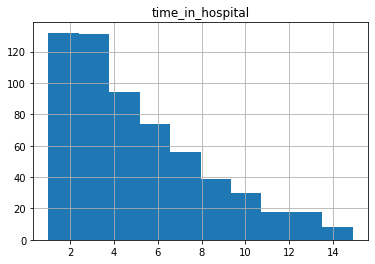

In [7]:
time_column = 'time_in_hospital'
hist_plot = train_data.hist(column=time_column)

We again call `fit()`, imposing a time-limit this time (in seconds), and also demonstrate a shorthand method to evaluate the resulting model's predictive performance on the test data (which here still contain the label column):

In [8]:
predictor_time = task.fit(train_data=train_data, output_directory="agModels-predictTime", 
                          label=time_column, time_limits=30)
performance = predictor_time.evaluate(test_data) # another way of gauging predictor accuracy besides `evaluate_predictions()`

Beginning AutoGluon training ... Time limit = 30s
AutoGluon will save models to agModels-predictTime/
AutoGluon Version:  0.0.13b20200731
Train Data Rows:    600
Train Data Columns: 47
Preprocessing data ...
Here are the first 10 unique label values in your data:  [1.5, 3.0, 2.3, 1.7000000000000002, 3.9, 4.3, 5.5, 13.2, 12.4, 9.7]
AutoGluon infers your prediction problem is: regression  (because dtype of label-column == float and many unique label-values observed).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Feature Generator processed 600 data points with 33 features
Original Features (raw dtypes):
	object features: 26
	int64 features: 7
Original Features (inferred dtypes):
	object features: 26
	int features: 7
Generated Features (special dtypes):
Processed Features (raw dtypes):
	int features: 7
	category features: 26
Processed Features:
	int features: 7
	category features:

Predictive performance on given dataset: root_mean_squared_error = 2.5721178269000005


Note that we didn’t even need to tell AutoGluon this is a regression problem, it automatically inferred this from the data and reported an appropriate performance metric (RMSE by default). For evaluation metrics where higher values are worse (like RMSE), AutoGluon may sometimes flips their sign and print them as *negative* values during training (as it internally assumes higher values are better).

## Description of fit():
    
Let's revisit our original `predictor` (for predicting the **readmitted** variable) and see what happened during `fit()`.

Since there are only three possible values of the class variable, this was a 3-class classification problem, for which an appropriate performance metric is accuracy. 
AutoGluon automatically infers this if unspecified, but you can explicitly specify these things via the `problem_type` and  `eval_metric` [arguments of `fit()`](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.TabularPrediction.fit) and AutoGluon will tailor its models to optimize your metric. 
AutoGluon also infers the type of each feature (i.e. which columns contain continuous numbers vs. discrete categories) and can automatically handle common issues like missing data and normalizing numerical features as necessary.

In [9]:
print("AutoGluon infers prediction problem is of type:", predictor.problem_type)
print("AutoGluon assigned the features to the following types:")
pprint.pprint(dict(predictor.feature_types.feature_types_raw))

AutoGluon infers prediction problem is of type: multiclass
AutoGluon assigned the features to the following types:
{'category': ['gender',
              'age',
              'admission_type_id',
              'discharge_disposition_id',
              'admission_source_id',
              'medical_specialty',
              'diag_1',
              'diag_2',
              'diag_3',
              'max_glu_serum',
              'A1Cresult',
              'metformin',
              'repaglinide',
              'glimepiride',
              'glipizide',
              'glyburide',
              'tolbutamide',
              'pioglitazone',
              'rosiglitazone',
              'acarbose',
              'troglitazone',
              'tolazamide',
              'insulin',
              'change',
              'diabetesMed'],
 'float': ['time_in_hospital'],
 'int': ['num_lab_procedures',
         'num_procedures',
         'num_medications',
         'number_outpatient',
         'number_emer

We did not specify separate validation data and so AutoGluon automatically choses a random training/validation split of the data. The data used for validation is seperated from the training data and is used to determine the models (and possibly hyperparameter-values) that produce the best results.  Rather than just a single model, AutoGluon trains multiple models and ensembles them together to ensure superior predictive performance.  By default, AutoGluon tries to fit various types of models including neural networks and various sorts of tree ensembles. 

For TabularPrediction tasks, `fit()` returns a Predictor object. Besides inference, this object can also be used to view a summary of what happened during `fit()`:

In [10]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                         model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer
0      weighted_ensemble_k0_l1   0.658333       0.165535   7.317772                0.001362           0.479501            1       True
1           LightGBMClassifier   0.650000       0.031892   6.098786                0.031892           6.098786            0       True
2           CatboostClassifier   0.616667       0.036838  42.824128                0.036838          42.824128            0       True
3   RandomForestClassifierEntr   0.608333       0.139243   0.808625                0.139243           0.808625            0       True
4     LightGBMClassifierCustom   0.600000       0.033570   2.430807                0.033570           2.430807            0       True
5   RandomForestClassifierGini   0.591667       0.131530   0.956434                0.131530           0.956434            0     

From this summary, we can see that AutoGluon trained many different types of models as well as an ensemble of the best-performing models, which combines their predictions in a weighted manner. Each type of model has various hyperparameters, which the user would traditionally have to specify. 
Here, AutoGluon is simply using fixed default values for these hyperparameters which are known to typically work well (the **LightGBMClassifierCustom** model here is a second **LightGBMClassifier** where these two models use very different default hyperparameter configurations that are both known to work well). 

The summary also describes the actual models that were trained during fit and how well each model performed on the held-out validation data (`score_val` column, which lists *accuracy* in this case), how long the model took to produce predictions on the validation data (`pred_time_val`), and how long the model was trained for (`fit_time`). 
The `stack_level` column distinguishes models which operate on the data directly (`stack_level = 0`) vs. models which combine the predictions of (multiple) other models (`stack_level = 1`) like the weighted-ensemble. 

We can also perform a similar evaluation of each trained model over our test data:

In [11]:
model_perf = predictor.leaderboard(test_data, silent=True)
display(model_perf)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer
0,ExtraTreesClassifierEntr,0.548333,0.591667,0.199204,0.141177,0.723158,0.199204,0.141177,0.723158,0,True
1,ExtraTreesClassifierGini,0.546667,0.566667,0.313916,0.132281,0.739485,0.313916,0.132281,0.739485,0,True
2,NeuralNetClassifier,0.545000,0.508333,0.339290,0.076282,6.777301,0.339290,0.076282,6.777301,0,True
3,RandomForestClassifierGini,0.535000,0.591667,0.142991,0.131530,0.956434,0.142991,0.131530,0.956434,0,True
4,LightGBMClassifier,0.530000,0.650000,0.040716,0.031892,6.098786,0.040716,0.031892,6.098786,0,True
5,RandomForestClassifierEntr,0.528333,0.608333,0.140743,0.139243,0.808625,0.140743,0.139243,0.808625,0,True
6,weighted_ensemble_k0_l1,0.523333,0.658333,0.360978,0.165535,7.317772,0.006346,0.001362,0.479501,1,True
7,CatboostClassifier,0.518333,0.616667,0.052483,0.036838,42.824128,0.052483,0.036838,42.824128,0,True
8,LightGBMClassifierCustom,0.493333,0.600000,0.034328,0.033570,2.430807,0.034328,0.033570,2.430807,0,True
9,KNeighborsClassifierDist,0.448333,0.533333,0.110443,0.105541,0.004107,0.110443,0.105541,0.004107,0,True


Note that the performance of many models decreased on the test data, because even though the validation data was held-out during the optimization of individual models, certain training decisions were still made on the basis of this validation-set thus leading to slight overfitting. This includes decisions like: when to early-stop iteratively trained models like the neural network and gradient boosted trees, as well as what weights to use for combining different models' predictions in the weighted-ensemble. The more decisions that are made based on validation data, the less reliable performance-estimates obtained from this data become (particularly under extensive hyperparameter-tuning). This is why it's critical to only present the test data *after* training has completed to obtain an unbiased estimate of the true predictive performance.

For posterity, we show how to predict class-probabilities rather than class-labels with AutoGluon. These are often desired in settings where we want to: gauge the confidence in predictions, rank individuals (here patients based on their estimated readmission probability), or select a different probability-threshold to use in decision-making (eg. if certain types of misclassification errors are more costly than others).

In [12]:
y_predprob = predictor.predict_proba(test_data)
display(pd.DataFrame(y_predprob,columns=predictor.class_labels))

,<30,>30,NO
0,0.106860,0.069708,0.823432
1,0.053784,0.384020,0.562196
2,0.465354,0.111395,0.423251
3,0.529098,0.210637,0.260265
4,0.011000,0.181537,0.807464
...,...,...,...
595,0.030304,0.697547,0.272150
596,0.043840,0.168644,0.787517
597,0.044705,0.682842,0.272454
598,0.110309,0.358272,0.531419


When we call `predict()`, AutoGluon automatically predicts with the model that displayed the best validation performance (i.e. the weighted-ensemble). We can instead specify which model to use for predictions like this:

In [13]:
predictor.predict(test_data[:20], model='NeuralNetClassifier')

array(['>30', 'NO', 'NO', 'NO', 'NO', '>30', '>30', 'NO', 'NO', 'NO',
       '>30', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO'],
      dtype=object)

**Data Formats:** 
AutoGluon can currently operate on data tables already loaded into Python as [pandas DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), or those stored in files of [CSV format](https://en.wikipedia.org/wiki/Comma-separated_values) or [Parquet format](https://databricks.com/glossary/what-is-parquet). If your data live in multiple tables, you will first need to [join](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) them into a single table whose rows correspond to statistically independent observations (datapoints) and columns correspond to different features (aka. variables/covariates). 

## References

[**AutoGluon Documentation** (autogluon.mxnet.io)](https://autogluon.mxnet.io/api/autogluon.task.html)

Erickson et al. [**AutoGluon-Tabular: Robust and Accurate AutoML for Structured Data**](https://arxiv.org/abs/2003.06505). *Arxiv*, 2020.